In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
import scipy.stats as stats
from scipy.stats import norm
import pandahouse as ph

from tqdm.auto import tqdm

plt.style.use('ggplot')

<h1><center>E-Learning A/B test</center></h1>

### Task 1. A/B–тестирование
    1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

    1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
    
    1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

    1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

##### загрузим данные и предварительно исследуем их

In [2]:
groups = 'https://disk.yandex.ru/d/lknJyFiqOt3IMA'
groups_add = 'https://disk.yandex.ru/d/KQ4jmHlH1ATDgw'
active_studs = 'https://disk.yandex.ru/d/_gI_QbjQJwah4Q'
checks = 'https://disk.yandex.ru/d/45Ox3RS-gfWL7w'

In [3]:
def get_data(file_url, sep=None): 
    if sep is None:
        sep = ';'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=file_url))
    r = requests.get(final_url)
    download_url = r.json()['href']
    df = pd.read_csv(download_url, sep=sep)
    return df

In [4]:
groups = get_data(groups)
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups_add = get_data(groups_add, sep=',')
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
active_studs = get_data(active_studs)
active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
checks = get_data(checks)
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
groups.shape  # в общем файле 74484 строки

(74484, 2)

In [9]:
groups_add.shape  # добавочные 92 строки

(92, 2)

In [15]:
active_studs.shape  # заходили на сайт во время эксперимента

(8341, 1)

In [10]:
checks.shape  # купили во время эксперимента

(541, 2)

In [11]:
groups_merg = pd.concat([groups, groups_add], ignore_index=True)  # соединяем датафреймы

In [12]:
groups.shape[0] + groups_add.shape[0] == groups_merg.shape[0]  # проверяем все ли на месте

True

In [13]:
groups.id.nunique() + groups_add.id.nunique() 

74576

In [14]:
groups_merg.id.nunique()

74576

In [15]:
active_df = pd.merge(active_studs, groups_merg, left_on='student_id', right_on='id', how='inner')  # мерджим
active_df = active_df[['id', 'grp']]

In [17]:
active_df.head(5)

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [18]:
active_df.id.nunique()  # проверяем, что ничего не потеряли

8341

In [19]:
active_studs.student_id.nunique()

8341

In [20]:
active_df.query('grp == "A"').id.nunique() + active_df.query('grp == "B"').id.nunique()

8341

In [21]:
active_df.isnull().sum()  # проверка на NaN

id     0
grp    0
dtype: int64

In [22]:
abtest = pd.merge(active_df, checks, left_on='id', right_on='student_id', how='left')
abtest = abtest[['id', 'grp', 'rev']]
abtest = abtest.fillna(0)

In [23]:
abtest.head(5)

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [24]:
abtest.shape

(8341, 3)

In [25]:
abtest.query('rev > 0').id.nunique()  # в эксперимент попало всего 392 заплативших пользователя

392

In [26]:
checks.student_id.nunique()  # купили 541

541

##### Обнаружили, что 149 чеков не попали в выборку. Скорее всего это могут быть автоплатежи по старым подпискам, их не учитываем. Далее подробнее рассмотрим данные в выборках.

E:\Users\snkr1\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

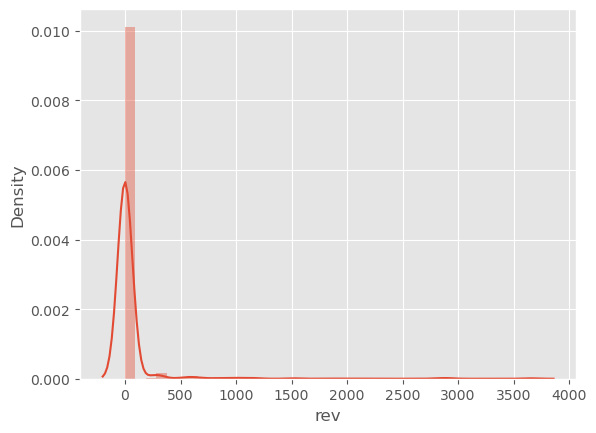

In [32]:
sns.distplot(abtest.query('grp == "A"').rev, kde=True)  # смотрим данные в выборке А, заметных выбросов нет.

E:\Users\snkr1\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

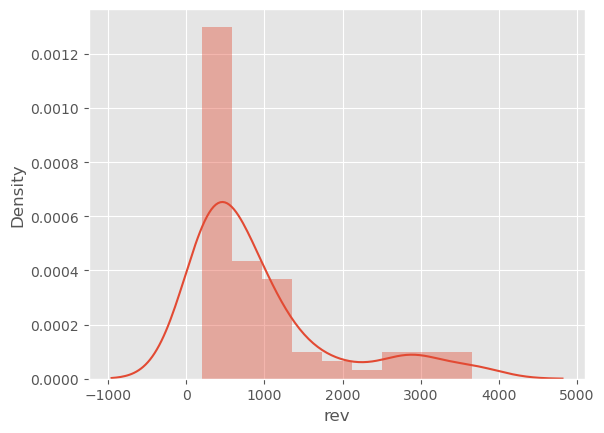

In [57]:
sns.distplot(abtest.query('grp == "A" and rev > 0').rev, kde=True)  # наибольшее число покупок примерно 
# в районе 100 - 1200 у.е.

Проверим на нормальность распределений в группе A, это поможет нам обосновать выбор статистического метода

In [27]:
stats.shapiro(abtest.query('grp == "A"').rev)  # распределение отколняется от нормального

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

In [28]:
stats.shapiro(abtest.query('grp == "A" and rev > 0').rev)  # распределение отколняется от нормального

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

Далее рассмотрим группу "B"

E:\Users\snkr1\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

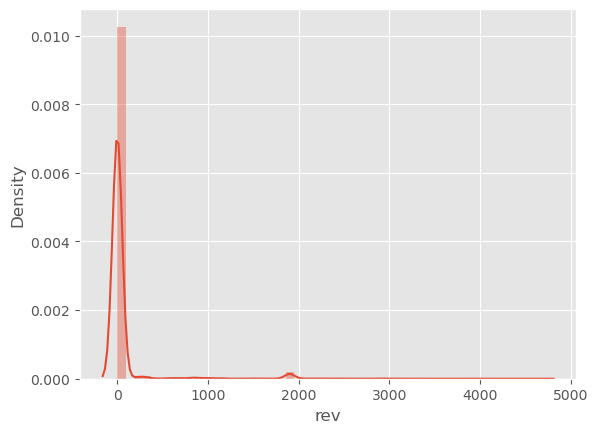

In [33]:
sns.distplot(abtest.query('grp == "B"').rev, kde=True)  # можно заметить всплеск в районе двух тысяч

E:\Users\snkr1\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

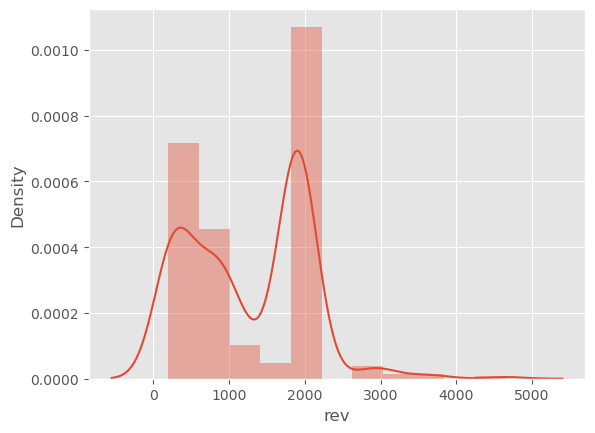

In [58]:
sns.distplot(abtest.query('grp == "B" and rev > 0').rev, kde=True)  # заметный "всплеск" покупок ценой 2000 в группе 'B'

Проверим на нормальность распределений в группе B

In [29]:
stats.shapiro(abtest.query('grp == "B"').rev)  # распределение отколняется от нормального

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

In [30]:
stats.shapiro(abtest.query('grp == "B" and rev > 0').rev)  # распределение отколняется от нормального

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

##### распределения во всех выборках отклоняются от нормального, это можно было наблюдать и на представленных графиках. Обнаружены всплески в районе ценовой категории 2000, попробуем еще более подробнее посмотреть на эти данные.

In [31]:
abtest.query('grp == "B" and rev > 0').groupby('rev', as_index=False).agg({'id': 'count'})
# обнаружили значение 1900.0001

,rev,id
0,199.0000,27
1,290.0000,45
2,398.0000,6
3,489.0000,1
4,580.0000,5
5,590.0000,6
6,597.0000,1
7,690.0000,13
8,796.0000,1
9,840.0000,21


##### сразу же обратим внимание на значение 1900.0001, которое встречается 35 раз, когда как остальные значения целые (без .0001). Значение 1900.0001 может быть результатом ошибок округления или представления чисел с плавающей запятой в Python. Округлим эти значения в одну ценовую категорию.

In [33]:
abtest1 = abtest.copy()

In [34]:
abtest1['rev'] = abtest1['rev'].round()

In [35]:
abtest1.query('grp == "B" and rev > 0').groupby('rev', as_index=False).agg({'id': 'count'})

,rev,id
0,199.0,27
1,290.0,45
2,398.0,6
3,489.0,1
4,580.0,5
5,590.0,6
6,597.0,1
7,690.0,13
8,796.0,1
9,840.0,21


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


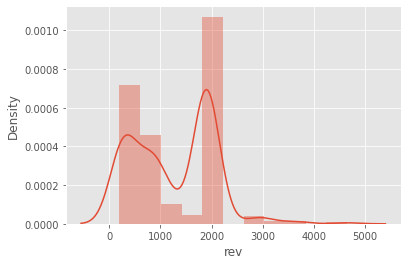

In [45]:
sns.distplot(abtest1.query('grp == "B" and rev > 0').rev, kde=True)  # после округления значений имеем 128 
# наблюдений в ценовой категории 1900

   ##### Итак механика оплаты на сайтах относится к способу, с помощью которого пользователи могут совершать платежи за товары или услуги, предлагаемые на сайте. Она включает в себя различные аспекты, такие как доступные способы оплаты (например, кредитные карты, электронные платежи, банковские переводы), процесс оплаты (одношаговый или многошаговый), а также условия и правила оплаты (например, возврат средств, сроки оплаты). Может ли это влиять на всплеск одной или нескольких конкретных ценовых категорий? Вцелом может, например если например предложены условия кешбека или рассрочки, что стало мотивацией для покупки именно популярных курсов. В этом случае это может иметь эффект для увеличенния покупок в конкретных ценовых категориях. 

##### На какие метрики следует обратить внимание? Нам доступны метрики Conversion Rate, Average Revenue per User(ARPU) и Average Revenue per Paying User(ARPPU). Механика оплаты может оказывать значительное влияние, в-первую очередь, на *конверсию в покупку*(CR). Например, если процесс оплаты слишком сложен или требует слишком много информации от пользователя, это может отпугнуть покупателей и снизить вероятность успешного завершения покупки. Во-вторых, в нашем случае, где механика может быть завязана и на "маркетинговый" эффект, также имеет смысл посмотреть на более "глобальную" метрику, а именно, на APRU. ARPU может быть полезной метрикой при анализе улучшения механики оплаты, особенно если цель заключается в увеличении выручки от пользователей. При улучшении механики оплаты можно ожидать, что ARPU возрастет, если пользователи начнут чаще и/или больше тратить на сайте или в приложении. Нам интересно изучить общий эффект изменений механики оплаты на всех пользователей, включая их конверсию в платящих пользователей и ARPU. Исходя из вышенаписанного выбираем нашими основными метриками - CR и ARPU.

##### Выбор CR и ARPU в качестве главных метрик оценки основан на их важности для понимания эффективности изменений в механике или стратегии. CR отражает процент успешных событий (например, покупок или регистраций) от общего числа событий, что позволяет оценить эффективность механики оплаты или пользовательского вовлечения. ARPU, с другой стороны, измеряет средний доход, полученный от каждого пользователя, что является важным показателем для понимания финансовых результатов. Анализ CR и ARPU поможет определить, есть ли статистически значимые изменения в конверсии и доходности между группами, и, следовательно, позволит оценить эффективность внесенных изменений в механику оплаты или стратегию работы с пользователями. Исходя из этого гипотеза может быть сформулирована следующим образом: "Если мы поменяем механику оплаты услуг на сайте, то мы получим статзначимый прирост CR и ARPU"

In [46]:
ARPU = abtest1.groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'mean'})  # ARPU
ARPU

,grp,id,rev
0,A,1538,47.347204
1,B,6803,58.058798


In [47]:
ARPPU = abtest1.query('rev > 0').groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'mean'})  # ARPPU
ARPPU

,grp,id,rev
0,A,78,933.589744
1,B,314,1257.878981


In [48]:
metrics = pd.merge(ARPU, ARPPU, on='grp', how='inner')
columns = ['grp', 'arpu_num', 'arpu', 'arppu_num', 'arppu']
metrics.columns = columns
metrics['cr'] = (metrics.arppu_num / metrics.arpu_num) * 100
metrics = metrics.round(decimals=3)
metrics = metrics[['grp', 'arpu_num', 'arppu_num', 'cr', 'arpu', 'arppu']]

In [49]:
metrics  # основные метрики

,grp,arpu_num,arppu_num,cr,arpu,arppu
0,A,1538,78,5.072,47.347,933.590
1,B,6803,314,4.616,58.059,1257.879


##### Вывели для удобства метрики СR, APRU и ARPPU. Теперь их нужно проверить на статзначимые различия. Мы имеем распределение данных, которое отклоняется от нормального и существенно отличается в количестве наблюдений между группами A и B. Таким образом, при существенном отличии в количестве наблюдений между группами A и B и ненормальном распределении данных, рекомендуется использовать бутстрэп для анализа различий в нужной нам метрике ARPU. Также проверим и ARPPU, но все равно основной метрикой будем считать ARPU и СR вместе. Это позволит получить более надежную оценку изменений и учесть особенности выборки при проведении статистического анализа.

In [53]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 10000/10000 [00:03<00:00, 3224.94it/s]


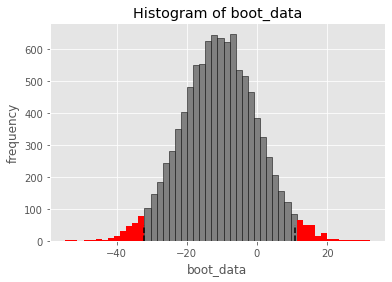

In [57]:
boot_arpu = get_bootstrap(abtest1.query('grp == "A"').rev, abtest1.query('grp == "B"').rev)

In [58]:
boot_arpu["p_value"]  # статистических различий в arpu нет

0.3199395268680858

100%|██████████| 10000/10000 [00:01<00:00, 5637.51it/s]


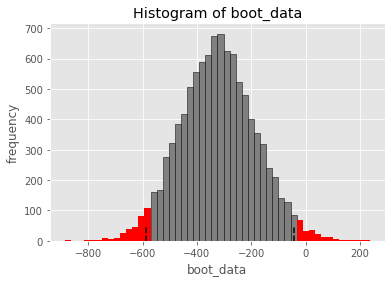

In [59]:
boot_arppu = get_bootstrap(abtest1.query('grp == "A" and rev > 0').rev, abtest1.query('grp == "B" and rev > 0').rev)

In [60]:
boot_arppu["p_value"]  # есть статистические различия в ARPPU

0.018985258654164335

##### Получены результаты: в ARPU нет статзначимых различий, а в ARPPU есть статзначимые различия. Так как эти результаты следует рассматриватьв  купе с CR, мы далее проверим CR, для этого введем категориальную переменную 'pur', где факт совершения покупки равен 1, если нету факта то 0. И снова используем бутстреп.

In [61]:
abtest1['pur'] = abtest1['rev'].apply(lambda x: 0 if x == 0 else 1)

In [62]:
def get_bootstrap_difference(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.sum,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 10000/10000 [00:02<00:00, 3373.05it/s]


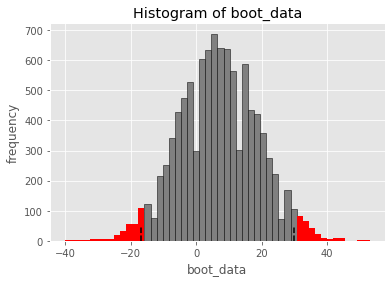

In [63]:
boot_cr = get_bootstrap_difference(abtest1.query('grp == "A"').pur, abtest1.query('grp == "B"').pur)

In [66]:
boot_cr["p_value"]  # нету статистической разницы в конверсиях между группами

0.5703849291002597

100%|██████████| 10000/10000 [00:03<00:00, 3097.00it/s]


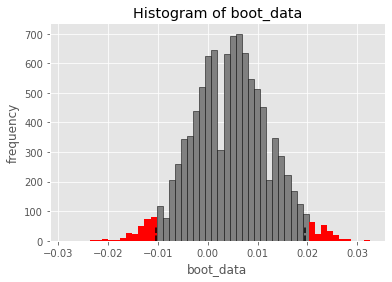

In [69]:
boot_cr1 = get_bootstrap(abtest1.query('grp == "A"').pur, abtest1.query('grp == "B"').pur)

In [70]:
boot_cr1["p_value"]  # нету статистической разницы в конверсиях между группами

0.553677036112106

##### p-value > 0.05 во всех тестах, значит нет статистически значимого различия конверсий в покупку между группами A и B. То есть, основываясь на этом, мы не можем сделать вывод о статистической значимости различий CR между группами.

### Task1 answer: В рамках проведенного исследования было проанализировано влияние изменения механики оплаты на метрики Conversion Rate (CR) и Average Revenue Per User (ARPU). Гипотеза, состоящая в том, что изменение механики оплаты будет иметь статистически значимое влияние на данные метрики, была подвергнута проверке. Для анализа были использованы данные из двух групп (группа A и группа B). Применяя соответствующие статистические методы, в частности бутстрэп-анализ, были получены следующие результаты: 
   - Conversion Rate (CR): После внесения изменений в механику оплаты не было обнаружено статистически значимых различий в CR между группами A и B. Это означает, что изменение механики оплаты не привело к существенным изменениям в проценте успешных событий от общего числа событий в обеих группах.

   - Average Revenue Per User (ARPU): Анализ ARPU также не выявил статистически значимых различий между группами A и B после изменения механики оплаты. Средний доход на пользователя оставался стабильным в обеих группах.

### На основе полученных результатов можно сделать вывод, что изменение механики оплаты не привело к статистически значимым изменениям в CR и ARPU. Это означает, что внесенные изменения не оказали существенного влияния на эти метрики и не стоит запускать новую механику на всех пользователей.

<font size="1">PS. Важно отметить, что проведенный анализ основан на доступных данных и методах, которые были выбраны для данного исследования. Результаты могут быть специфичны для данного контекста исследования. В данном случае выявленные различия в ARPPU, все таки говорят о том, что в действительности тут есть влияния маркетингового характера. Все-таки для чистоты A/B-тестов нужно изолировать изменяемые переменные для более точной оценки и понимания их влияния на метрики и результаты. Поэтому в идеале следует избегать одновременного изменения и механики оплаты, и маркетинговых акций в рамках одного A/B-теста.Если мы хотим оценить влияние механики оплаты на метрики, то лучше провести отдельный A/B-тест, в котором изменяется только механика оплаты, а все остальные факторы остаются неизменными. Таким образом, мы сможем более точно измерить и сравнить эффекты разных вариантов механики оплаты на метрики, без влияния других переменных. И когда мы хотим оценить влияние маркетинговых акций, включая изменение цены или предложения, то в таком случае важно учитывать, что механика оплаты может быть одним из факторов, влияющих на реакцию потребителей на акцию. Поэтому при проведении A/B-тестов с маркетинговыми акциями рекомендуется контролировать и стандартизировать механику оплаты, чтобы минимизировать ее влияние на результаты. В целом, отделение и изоляция переменных, таких как механика оплаты и маркетинговые акции, в A/B-тестировании помогут получить более точные и надежные данные о влиянии каждого фактора на метрики и принять обоснованные решения на основе этих результатов. По итогам данного исследования можно рекомендовать провести дополнительные исследования с учетом вышеизложенных факторов.</font>

### Task 2. SQL
    2.1 Очень усердные ученики.

    2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

2.1.2 Задача

Дана таблица default.peas:

In [3]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        st_id,
        toDateTime(timest) AS timest,
        correct,
        subject 
    FROM default.peas
    LIMIT 5
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
peas = ph.read_clickhouse(query=q, connection=connection_default)
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [4]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT count() AS count_good_stud
    FROM
    (
        SELECT st_id
        FROM default.peas
        WHERE toYear(timest) * 12 + toMonth(timest) = (
            SELECT max(toYear(timest) * 12 + toMonth(timest)) FROM default.peas
        )
        GROUP BY st_id
        HAVING sum(correct) >= 20
    )
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
good_studs = ph.read_clickhouse(query=q, connection=connection_default)
good_studs

,count_good_stud
0,136


### Task 2.1.2 answer: 136 усердных студентов правильно решивших от 20 задач за текущий месяц! В базе данных представлена информация только за 1 месяц октябрь 21года, тоесть за текущий месяц май 2023 года в базе нету никого. Поэтому будем считать что текущий месяц это последний релевантый месяц в базе данных.

    2.2 Оптимизация воронки

    2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

    2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

In [9]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT * FROM default.studs
    LIMIT 5
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
studs = ph.read_clickhouse(query=q, connection=connection_default)
studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


и default.final_project_check:

In [12]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT st_id,
        toDateTime(sale_time) AS sale_time,
        money,
        subject
    FROM default.final_project_check
    LIMIT 5
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
project_check = ph.read_clickhouse(query=q, connection=connection_default)
project_check

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [5]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
SELECT
    A.test_grp AS group,
    SUM(C.money) / COUNT(DISTINCT A.st_id) AS ARPU,
    SUM(CASE WHEN B.correct_all > 10 THEN C.money ELSE 0 END) / 
        COUNT(DISTINCT CASE WHEN B.correct_all > 10 THEN A.st_id END) AS ARPAU,
    (COUNT(DISTINCT CASE WHEN C.money != 0 THEN C.st_id END) / COUNT(DISTINCT A.st_id))*100 AS CR_all,
    (COUNT(DISTINCT CASE WHEN C.money != 0 AND B.correct_all > 
        10 THEN A.st_id END) / COUNT(DISTINCT CASE WHEN B.correct_all > 10 THEN A.st_id END))*100 AS CR_active_all,
    (COUNT(DISTINCT CASE WHEN C.subject = 
        'Math' AND B.correct_math >= 2 AND C.money != 0 THEN A.st_id END) / COUNT(DISTINCT CASE WHEN B.correct_math >= 
            2 THEN A.st_id END))*100 AS CR_active_math
FROM 
    default.studs AS A
LEFT JOIN default.final_project_check AS C
    ON A.st_id = C.st_id
LEFT JOIN (
    SELECT
        st_id,
        COUNT(DISTINCT CASE WHEN correct = 1 THEN timest END) AS correct_all,
        SUM(CASE WHEN subject = 'Math' THEN correct END) AS correct_math
    FROM
        default.peas
    GROUP BY
        st_id
) AS B
ON A.st_id = B.st_id
GROUP BY
    group
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
project_check = ph.read_clickhouse(query=q, connection=connection_default)
project_check

,group,ARPU,ARPAU,CR_all,CR_active_all,CR_active_math
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


### Task 2.2.2 answer: Получили указанные метрики в один запрос. Пилотная группа показывает улучшение по всем метрикам.

### Task 3. Python
    3.1 Задача
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

    3.2 Задача
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [7]:
def metrics_update(groups_add):
    """
    Обновляет метрики ARPU, ARPPU и CR на основе данных из разных источников.

    Аргументы:
    - groups_add (str): Ссылка на файл с дополнительными данными о группах.

    Возвращает:
    - metrics (pandas.DataFrame): Таблица с обновленными метриками ARPU, ARPPU и CR.

    Примечания:
    - Функция загружает данные из разных источников.
    - Объединяет данные о группах.
    - Вычисляет ARPU (средний доход на пользователя) и ARPPU (средний доход на платящего пользователя).
    - Вычисляет CR (конверсию) - отношение количества платящих пользователей к общему количеству пользователей в группе.
    - Возвращает таблицу с обновленными метриками.

    """
    # встраиваем функцию загрузки
    def get_data(file_url, sep=None):
        if sep is None:
            sep = ';'
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        final_url = base_url + urlencode(dict(public_key=file_url))
        r = requests.get(final_url)
        download_url = r.json()['href']
        df = pd.read_csv(download_url, sep=sep)
        return df

    # ccылки на данные
    groups = 'https://disk.yandex.ru/d/lknJyFiqOt3IMA'
    active_studs = 'https://disk.yandex.ru/d/_gI_QbjQJwah4Q'
    checks = 'https://disk.yandex.ru/d/45Ox3RS-gfWL7w'

    # загрузка самих данных
    groups = get_data(groups)
    groups_add = get_data(groups_add, sep=',')
    active_studs = get_data(active_studs)
    checks = get_data(checks)

    # все тоже самое из кода первого задания
    concat = pd.concat([groups, groups_add], ignore_index=True)
    active = pd.merge(active_studs, concat, left_on='student_id', right_on='id', how='inner')
    active = active[['id', 'grp']]

    df_update = pd.merge(active, checks, left_on='id', right_on='student_id', how='left')
    df_update = df_update[['id', 'grp', 'rev']]
    df_update = df_update.fillna(0)

    ARPU = df_update.groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'mean'})
    ARPPU = df_update.query('rev > 0').groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'mean'})
    metrics = pd.merge(ARPU, ARPPU, on='grp', how='inner')
    columns = ['grp', 'arpu_num', 'arpu', 'arppu_num', 'arppu']
    metrics.columns = columns
    metrics['cr'] = (metrics.arppu_num / metrics.arpu_num) * 100
    metrics = metrics.round(decimals=3)
    metrics = metrics[['grp', 'arpu_num', 'arppu_num', 'cr', 'arpu', 'arppu']]

    return metrics

In [8]:
groups_add = 'https://disk.yandex.ru/d/KQ4jmHlH1ATDgw'
updated_metrics = metrics_update(groups_add)
updated_metrics

,grp,arpu_num,arppu_num,cr,arpu,arppu
0,A,1538,78,5.072,47.347,933.590
1,B,6803,314,4.616,58.059,1257.879


In [15]:
def plot_metrics(metrics):
    """
    Визуализирует метрики ARPU, ARPPU и CR в виде графиков.

    Аргументы:
    - metrics (pandas.DataFrame): Таблица с метриками ARPU, ARPPU и CR.

    Возвращает:
    - Визуализирует метрику ARPU, ARPPU и CR в виде гистограммы для каждой группы.
    - Визуализирует размер выборки для каждой группы.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # ARPU
    axs[0, 0].bar(metrics['grp'], metrics['arpu'], color='tab:blue')
    axs[0, 0].set_title('ARPU')
    axs[0, 0].set_xlabel('Group')
    axs[0, 0].set_ylabel('ARPU')
    add_value_labels(axs[0, 0]) 

    # ARPPU
    axs[0, 1].bar(metrics['grp'], metrics['arppu'], color='tab:blue')
    axs[0, 1].set_title('ARPPU')
    axs[0, 1].set_xlabel('Group')
    axs[0, 1].set_ylabel('ARPPU')
    add_value_labels(axs[0, 1]) 

    # Conversion Rate
    axs[1, 0].bar(metrics['grp'], metrics['cr'], color='tab:blue')
    axs[1, 0].set_title('Conversion Rate')
    axs[1, 0].set_xlabel('Group')
    axs[1, 0].set_ylabel('Conversion Rate')
    add_value_labels(axs[1, 0]) 

    # Size
    axs[1, 1].bar(metrics['grp'], metrics['arpu_num'], label='ARPU', color='tab:blue')
    axs[1, 1].bar(metrics['grp'], metrics['arppu_num'], label='ARPPU')
    axs[1, 1].set_title('Sample Size')
    axs[1, 1].set_xlabel('Group')
    axs[1, 1].set_ylabel('Sampling')
    add_value_labels(axs[1, 1])
    axs[1, 1].legend()

    # tightfit
    fig.tight_layout()
    plt.show()

def add_value_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')

### Task 3 answer:

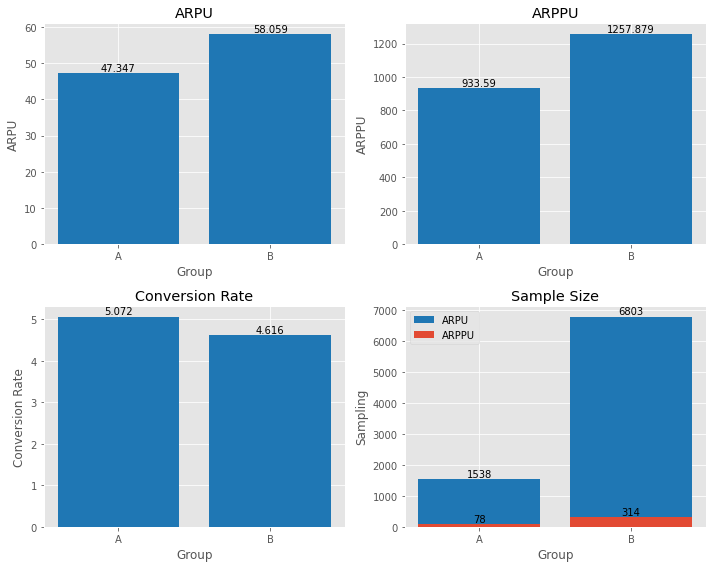

In [16]:
plot_metrics(updated_metrics)